# U-Net Image Segmentation in Keras
This Colab notebook is a U-Net implementation with TensorFlow 2 / Keras, trained for semantic segmentation on the Oxford-IIIT pet dataset.

## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import sys

2024-04-28 21:09:43.440799: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-28 21:09:43.964855: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/omirako/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tf.config.list_physical_devices('GPU')

2024-04-28 21:09:45.335899: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-28 21:09:45.372899: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-28 21:09:45.377372: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data

### Load dataset from TFDS

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True, data_dir='../datasets/')

2024-04-28 21:09:45.427755: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-28 21:09:45.430073: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-28 21:09:45.432193: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Take a look at the dataset info. Note the `test` and `train` data split is already built in the dataset.

In [4]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='../datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        

In [5]:
print(dataset)

{'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>, 'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}


In [6]:
print(dataset["train"])

<_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


### Data preprocessing

In [7]:
def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (128, 128), method="nearest")
    input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")

    return input_image, input_mask

In [8]:
def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        # Random flipping of the image and mask
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask

In [9]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1

    return input_image, input_mask

In [10]:
def load_image_train(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [11]:
def load_image_test(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [12]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [13]:
print(train_dataset)

<_ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))>


Create train, validation and test batches. Note we split the original `test_dataset` into validation and test batches.

In [14]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

In [15]:
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

In [16]:
print(train_batches)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.uint8, name=None))>


### Data Visualization

In [17]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ["Input Image", "True Mask", "Predicted Mask"]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

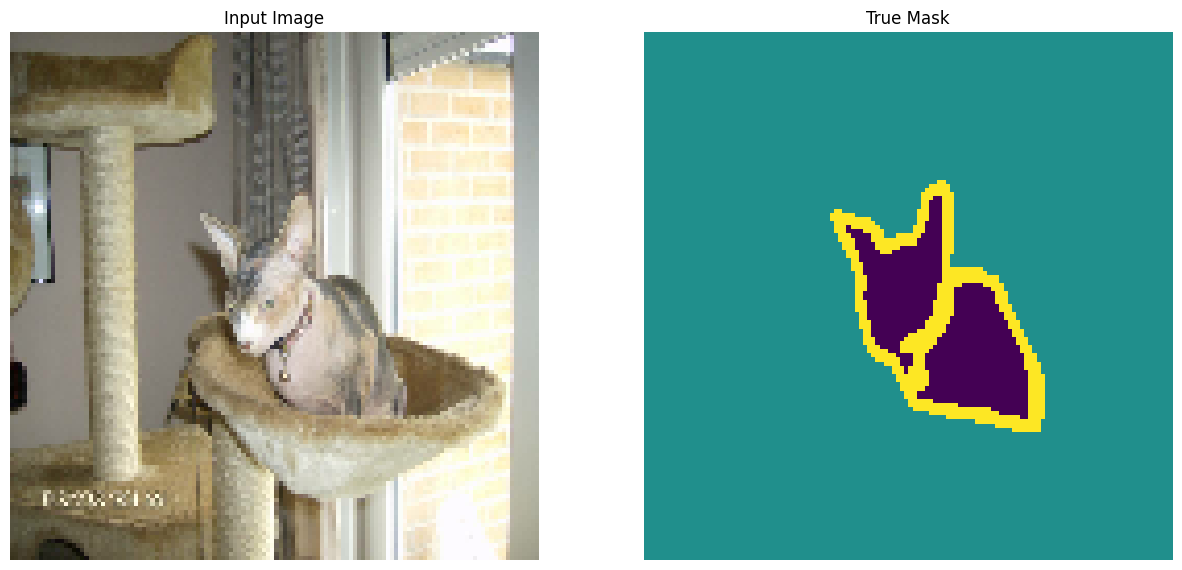

In [18]:
sample_batch = next(iter(test_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [66]:
# convert tensro to numpy array
sample_mask_array = sample_mask.numpy()

sample_mask_array.flatten()
# convert to pd series
import pandas as pd
sample_mask_series = pd.Series(sample_mask_array.flatten())
sample_mask_series.value_counts()

1    14658
0     1021
2      705
Name: count, dtype: int64

## U-Net Building blocks
Create the building blocks for making the components U-Net model.

In [19]:
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x

In [20]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f, p

In [21]:
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

## Build the U-Net Model

In [22]:
def build_unet_model():

    # inputs
    inputs = layers.Input(shape=(128,128,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [23]:
unet_model = build_unet_model()

In [24]:
unet_model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 16,    │          0 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ dropout_2[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 8, 8, 512) │          0 │ max_pooling2d_3[

 Total params: 34,513,475 (131.66 MB)

 Trainable params: 34,513,475 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

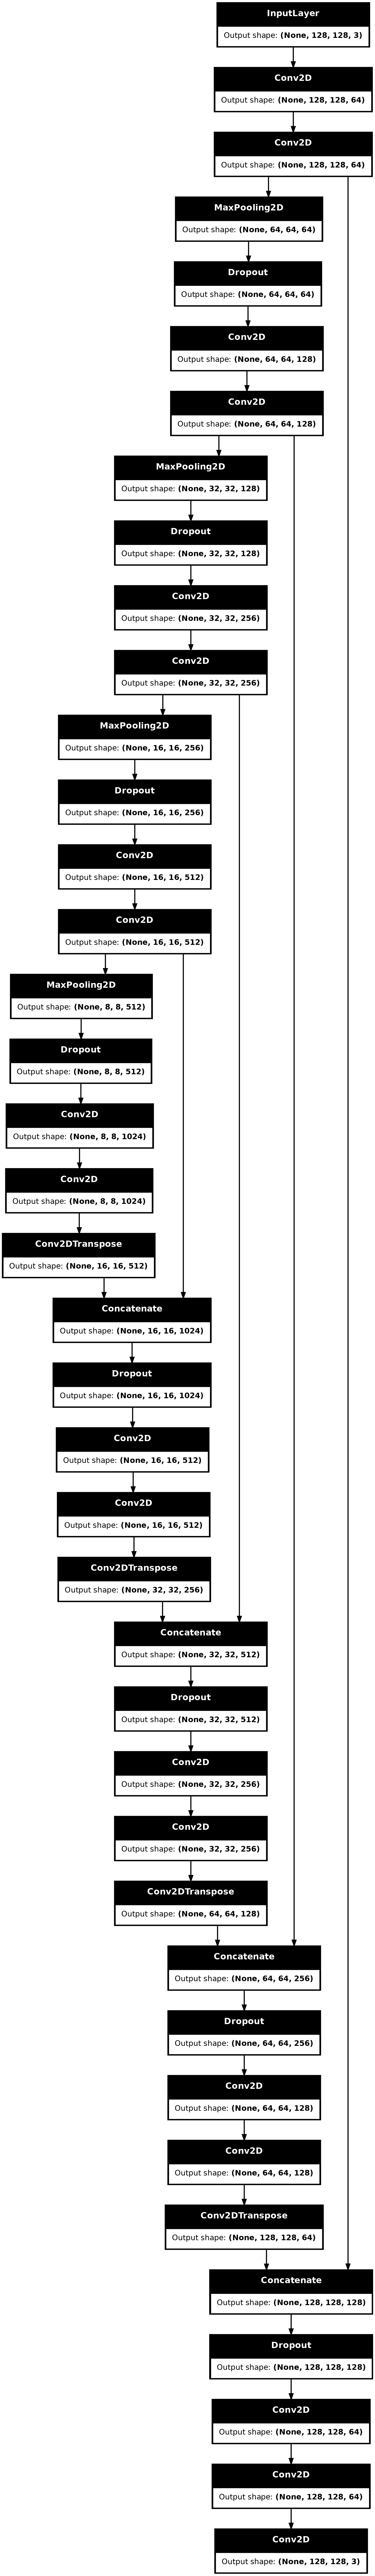

In [25]:
tf.keras.utils.plot_model(unet_model, show_shapes=True)

## Compile and Train U-Net

In [27]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss="sparse_categorical_crossentropy",
                   metrics=["accuracy"])

In [35]:
NUM_EPOCHS = 50

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=validation_batches)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.8866 - loss: 0.2920 - val_accuracy: 0.8654 - val_loss: 0.3618
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - accuracy: 0.8867 - loss: 0.2923 - val_accuracy: 0.8778 - val_loss: 0.3252
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 193ms/step - accuracy: 0.8913 - loss: 0.2807 - val_accuracy: 0.8741 - val_loss: 0.3446
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - accuracy: 0.8944 - loss: 0.2716 - val_accuracy: 0.8674 - val_loss: 0.3729
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step - accuracy: 0.8936 - loss: 0.2719 - val_accuracy: 0.8876 - val_loss: 0.3142
Epoch 6/50
 1/57 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.8996 - loss: 0.2583

2024-04-28 21:16:45.858618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-28 21:16:45.858659: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12157244726550071498
2024-04-28 21:16:45.858677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.8974 - loss: 0.2630 - val_accuracy: 0.8744 - val_loss: 0.3414
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - accuracy: 0.9001 - loss: 0.2565 - val_accuracy: 0.8840 - val_loss: 0.3242
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.9026 - loss: 0.2494 - val_accuracy: 0.8791 - val_loss: 0.3430
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.9054 - loss: 0.2417 - val_accuracy: 0.8762 - val_loss: 0.3611
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step - accuracy: 0.9083 - loss: 0.2336 - val_accuracy: 0.8926 - val_loss: 0.2920
Epoch 11/50
 1/57 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - accuracy: 0.9095 - loss: 0.2366

2024-04-28 21:17:40.830986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-28 21:17:40.831040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step - accuracy: 0.9072 - loss: 0.2375 - val_accuracy: 0.8857 - val_loss: 0.3315
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - accuracy: 0.9121 - loss: 0.2226 - val_accuracy: 0.8826 - val_loss: 0.3223
Epoch 13/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.9145 - loss: 0.2153 - val_accuracy: 0.8828 - val_loss: 0.3460
Epoch 14/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.9136 - loss: 0.2189 - val_accuracy: 0.8747 - val_loss: 0.4004
Epoch 15/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - accuracy: 0.9166 - loss: 0.2097 - val_accuracy: 0.8967 - val_loss: 0.2944
Epoch 16/50
 1/57 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.9150 - loss: 0.2165

2024-04-28 21:18:34.066731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-28 21:18:34.066759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-28 21:18:34.066771: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9003132443523735739
2024-04-28 21:18:34.066785: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12157244726550071498


57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step - accuracy: 0.9148 - loss: 0.2134 - val_accuracy: 0.8838 - val_loss: 0.3381
Epoch 17/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.9151 - loss: 0.2139 - val_accuracy: 0.8848 - val_loss: 0.3429
Epoch 18/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step - accuracy: 0.9177 - loss: 0.2073 - val_accuracy: 0.8824 - val_loss: 0.3620
Epoch 19/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.9202 - loss: 0.1984 - val_accuracy: 0.8792 - val_loss: 0.3800
Epoch 20/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step - accuracy: 0.9196 - loss: 0.2021 - val_accuracy: 0.8984 - val_loss: 0.2875
Epoch 21/50
 1/57 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.9186 - loss: 0.2003

2024-04-28 21:19:29.283309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-04-28 21:19:29.283340: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12157244726550071498
2024-04-28 21:19:29.283353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step - accuracy: 0.9233 - loss: 0.1906 - val_accuracy: 0.8897 - val_loss: 0.3432
Epoch 22/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - accuracy: 0.9266 - loss: 0.1814 - val_accuracy: 0.8866 - val_loss: 0.3563
Epoch 23/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - accuracy: 0.9244 - loss: 0.1883 - val_accuracy: 0.8812 - val_loss: 0.3918
Epoch 24/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.9261 - loss: 0.1815 - val_accuracy: 0.8853 - val_loss: 0.4017
Epoch 25/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - accuracy: 0.9302 - loss: 0.1713 - val_accuracy: 0.8981 - val_loss: 0.3216
Epoch 26/50
 1/57 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.9351 - loss: 0.1641

2024-04-28 21:20:24.375888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-28 21:20:24.375915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.9309 - loss: 0.1694 - val_accuracy: 0.8930 - val_loss: 0.3510
Epoch 27/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.9313 - loss: 0.1682 - val_accuracy: 0.8911 - val_loss: 0.3345
Epoch 28/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 200ms/step - accuracy: 0.9319 - loss: 0.1660 - val_accuracy: 0.8877 - val_loss: 0.3834
Epoch 29/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 200ms/step - accuracy: 0.9308 - loss: 0.1704 - val_accuracy: 0.8808 - val_loss: 0.4118
Epoch 30/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 193ms/step - accuracy: 0.9242 - loss: 0.1902 - val_accuracy: 0.8955 - val_loss: 0.3175
Epoch 31/50
 1/57 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - accuracy: 0.9223 - loss: 0.1938

2024-04-28 21:21:20.990070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-28 21:21:20.990100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-04-28 21:21:20.990112: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9003132443523735739
2024-04-28 21:21:20.990125: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12157244726550071498


57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - accuracy: 0.9263 - loss: 0.1834 - val_accuracy: 0.8878 - val_loss: 0.3609
Epoch 32/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 204ms/step - accuracy: 0.9335 - loss: 0.1635 - val_accuracy: 0.8949 - val_loss: 0.3685
Epoch 33/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.9338 - loss: 0.1612 - val_accuracy: 0.8896 - val_loss: 0.3877
Epoch 34/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 200ms/step - accuracy: 0.9368 - loss: 0.1525 - val_accuracy: 0.8868 - val_loss: 0.3877
Epoch 35/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 192ms/step - accuracy: 0.9357 - loss: 0.1568 - val_accuracy: 0.8973 - val_loss: 0.3072
Epoch 36/50
 1/57 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.9301 - loss: 0.1699

2024-04-28 21:22:17.685561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-28 21:22:17.685592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 205ms/step - accuracy: 0.9275 - loss: 0.1806 - val_accuracy: 0.8879 - val_loss: 0.3656
Epoch 37/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.9329 - loss: 0.1642 - val_accuracy: 0.8917 - val_loss: 0.3454
Epoch 38/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - accuracy: 0.9367 - loss: 0.1535 - val_accuracy: 0.8877 - val_loss: 0.3826
Epoch 39/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - accuracy: 0.9385 - loss: 0.1484 - val_accuracy: 0.8901 - val_loss: 0.4391
Epoch 40/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - accuracy: 0.9413 - loss: 0.1405 - val_accuracy: 0.9024 - val_loss: 0.3164
Epoch 41/50
 1/57 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.9394 - loss: 0.1433

2024-04-28 21:23:13.394633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-28 21:23:13.394658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 197ms/step - accuracy: 0.9426 - loss: 0.1365 - val_accuracy: 0.8939 - val_loss: 0.3901
Epoch 42/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - accuracy: 0.9438 - loss: 0.1333 - val_accuracy: 0.8956 - val_loss: 0.3647
Epoch 43/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - accuracy: 0.9423 - loss: 0.1375 - val_accuracy: 0.8880 - val_loss: 0.4109
Epoch 44/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.9411 - loss: 0.1406 - val_accuracy: 0.8873 - val_loss: 0.4168
Epoch 45/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - accuracy: 0.9419 - loss: 0.1389 - val_accuracy: 0.9028 - val_loss: 0.3181
Epoch 46/50
 1/57 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 0.9398 - loss: 0.1467

2024-04-28 21:24:08.586830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-28 21:24:08.586893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step - accuracy: 0.9418 - loss: 0.1396 - val_accuracy: 0.8930 - val_loss: 0.3976
Epoch 47/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - accuracy: 0.9412 - loss: 0.1414 - val_accuracy: 0.8902 - val_loss: 0.3487
Epoch 48/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.9373 - loss: 0.1534 - val_accuracy: 0.8854 - val_loss: 0.4133
Epoch 49/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.9388 - loss: 0.1479 - val_accuracy: 0.8798 - val_loss: 0.4174
Epoch 50/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step - accuracy: 0.9344 - loss: 0.1610 - val_accuracy: 0.8965 - val_loss: 0.3606


2024-04-28 21:25:03.635673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-28 21:25:03.635716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


## Learning curve from model history

In [39]:
def display_learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(NUM_EPOCHS)

    fig = plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validataion accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.show()

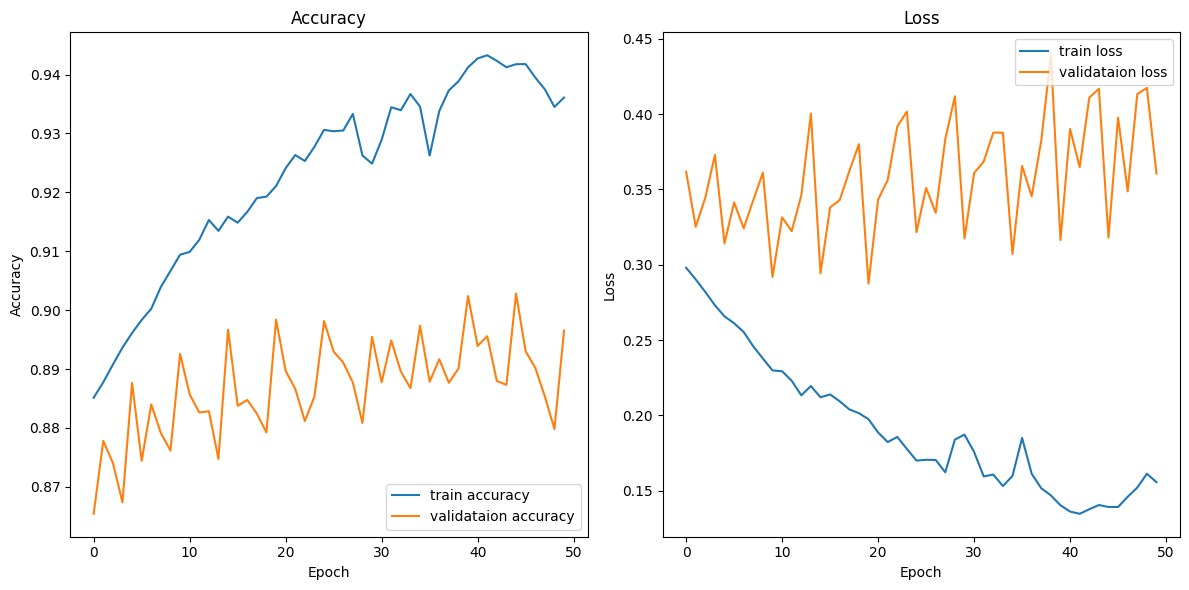

In [40]:
# Display learning curves
display_learning_curves(unet_model.history)

## Predictions with U-Net model
Let's try the trained U-Net model on a few samples from the test dataset.

In [41]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [42]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [43]:
count = 0
for i in test_batches:
    count +=1
print("number of batches:", count)

number of batches: 11


2024-04-28 21:25:57.221898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step 


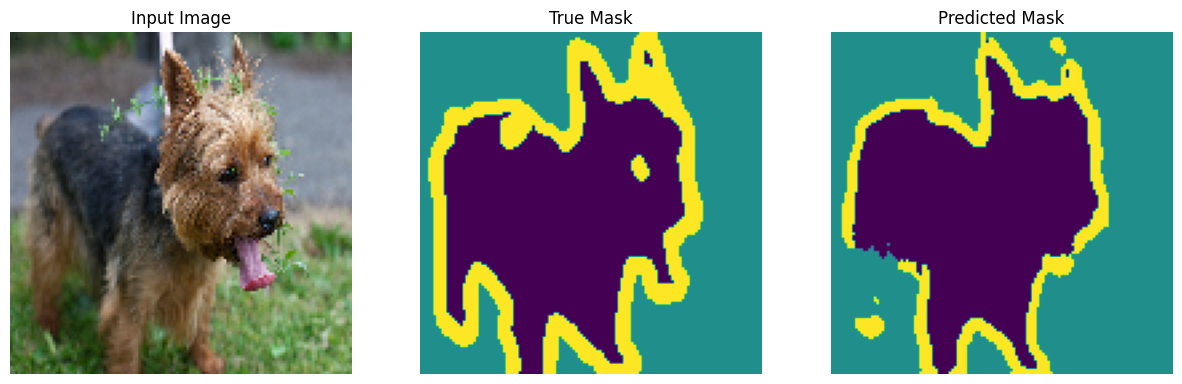

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


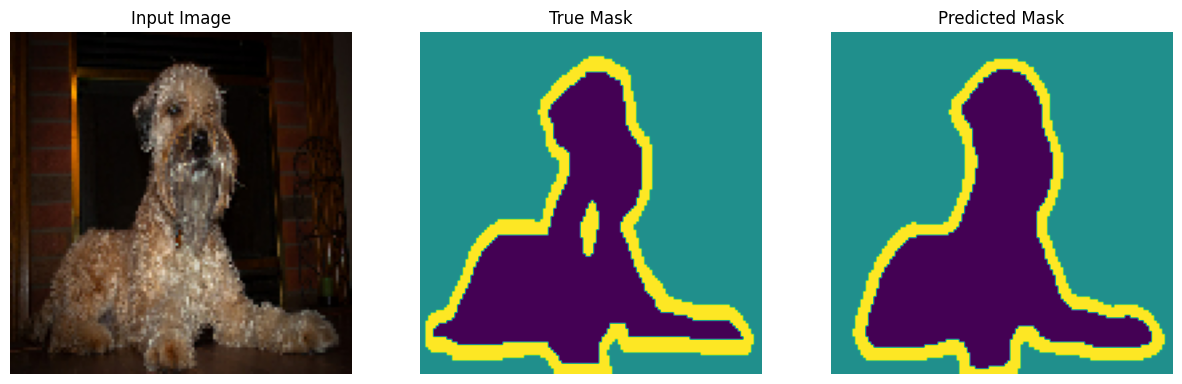

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


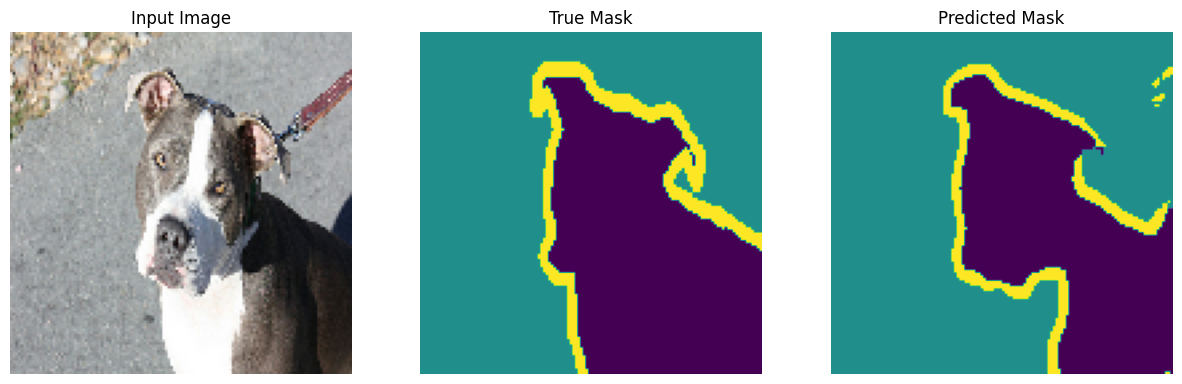

2024-04-28 21:26:00.475834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [44]:
show_predictions(test_batches.skip(5), 3)